In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from builtins import range
from sklearn.metrics import roc_auc_score
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram, Spectrogram
from global_config import *

Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [2]:
def data_gen(dataset_type, df_subset, ys, is_shuffle, batch_size=20):
    """Data generator.
    dataset_type: onset or segment
    df_subset: pandas dataframe, with rows subset
    ys: numpy arrays, N-by-8 one-hot-encoded labels
    is_shuffle: shuffle every batch if True.
    batch_size: integer, size of batch. len(df_subset) % batch_size should be 0.
    """
    if dataset_type == "onset":
        dir_pedal_npy = DIR_PEDAL_ONSET_NPY
    elif dataset_type == "segment":
        dir_pedal_npy = DIR_PEDAL_SEGMENT_NPY
    else:
        print("ERROR: dataset type must be either onset or segment!")
        
    n_data = len(df_subset)
    n_batch = n_data // batch_size
#     if n_data % batch_size != 0:
#         print("= WARNING =")
#         print("  n_data % batch_size != 0 but this code does not assume it")
#         print("  so the residual {} sample(s) will be ignored.".format(n_data % batch_size))

    while True:
        for batch_i in range(n_batch):
            if is_shuffle:
                batch_idxs = np.random.choice(n_data, batch_size, replace=False)
            else:
                batch_idxs = range(batch_i * batch_size, (batch_i + 1) * batch_size)

            src_batch = np.array([np.load(os.path.join(dir_pedal_npy, df_subset.loc[df_subset.index[i]].filepath.split('.')[0]+'.npy')) for i in batch_idxs],
                                 dtype=K.floatx())
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible

            y_batch = np.array([ys[i] for i in batch_idxs],
                               dtype=K.floatx())
            
            yield src_batch, y_batch
        
        
def get_callbacks(name,patience):
    if not os.path.exists(DIR_SAVE_MODEL):
        os.makedirs(DIR_SAVE_MODEL)    
    early_stopper = keras.callbacks.EarlyStopping(patience=patience)
    model_saver = keras.callbacks.ModelCheckpoint(os.path.join(DIR_SAVE_MODEL,"{}_best_model.h5".format(name)),
                                                  save_best_only=True)
    weight_saver = keras.callbacks.ModelCheckpoint(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(name)),
                                                   save_best_only=True,
                                                   save_weights_only=True)
    csv_logger = keras.callbacks.CSVLogger(os.path.join(DIR_SAVE_MODEL,"{}.log".format(name)))
    return [early_stopper, model_saver, weight_saver, csv_logger]

## Spectrogram vs Mel-Spectrogram using a simple conv3x3 model

In [3]:
def model_conv3x3_spectrogram(n_out, inputshape, out_activation='softmax'):
    """
    A simple conv3x3 model using spectrogram as input.
    """

    model = Sequential()
    model.add(Spectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, power_spectrogram=2.0, 
                          return_decibel_spectrogram=True, input_shape=inputshape))
    model.add(BatchNormalization(axis=channel_axis))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((4, 4), padding='same'))
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(n_out, activation=out_activation))

    return model

def model_conv3x3_melspectrogram(n_out, inputshape, out_activation='softmax'):
    """
    A simple conv3x3 model using mel spectrogram as input.
    """

    model = Sequential()
    model.add(Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, 
                             return_decibel_melgram=True,
                             input_shape=inputshape))
    model.add(BatchNormalization(axis=channel_axis))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(21, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((4, 4), padding='same'))
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(n_out, activation=out_activation))

    return model

In [3]:
reg_w = 1e-4
epochs = 50
patience = 10
confidence_interval_times = 10

In [7]:
dataset_types = ['onset', 'segment']
model_names = ['cnn3x3-spectrogram','cnn3x3-melspectrogram']
subonset_cnn3x3spectrogram_aucs, subonset_cnn3x3melspectrogram_aucs = [], []
subsegment_cnn3x3spectrogram_aucs, subsegment_cnn3x3melspectrogram_aucs = [], []

for dataset_type in dataset_types:
    print("=" * 60)
    print("Test on sub excerpts of {}.".format(dataset_type))
    if dataset_type == 'onset':
        typeshape = ONSET_INPUT_SHAPE
        batch_size = 256
    elif dataset_type == 'segment':
        typeshape = SEGMENT_INPUT_SHAPE
        batch_size = 128
        
    csv_path = os.path.join(DIR_PEDAL_METADATA, "pedal-{}_subdf.csv".format(dataset_type))
    tracks = pd.read_csv(csv_path)
    
    for model_name in model_names:

        print("-" * 40)
        print("We're gonna use {} model.".format(model_name))
        
        for experiment_indx in range(confidence_interval_times):
            print("--- experiment index of {} ---".format(experiment_indx))
            exp_name = 'sub-{}_{}_{}'.format(dataset_type, model_name, experiment_indx)

            training = tracks.loc[(tracks['category'] == 'train') & (tracks['interval_time'] == experiment_indx)]
            validation = tracks.loc[(tracks['category'] == 'valid') & (tracks['interval_time'] == experiment_indx)]

            # make labels as one-hot vector
            y_train = training.label.values
            y_valid = validation.label.values
            y_train = keras.utils.to_categorical(y_train, 2)
            y_valid = keras.utils.to_categorical(y_valid, 2)

            # preparing data generators
            steps_per_epoch = len(y_train) // batch_size
            gen_train = data_gen(dataset_type, training, y_train, True, batch_size=batch_size)
            gen_valid = data_gen(dataset_type, validation, y_valid, False, batch_size=batch_size)

            # callbacks
            callbacks = get_callbacks(name=exp_name, patience=patience)
            early_stopper, model_saver, weight_saver, csv_logger = callbacks

            print("Getting model...")
            if model_name == 'cnn3x3-spectrogram':
                model = model_conv3x3_spectrogram(n_out=2, inputshape=typeshape)
            elif model_name == 'cnn3x3-melspectrogram':
                model = model_conv3x3_melspectrogram(n_out=2, inputshape=typeshape)

            # model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
            model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
            # model.summary()

            print("Starting to train...")
            model.fit_generator(gen_train, steps_per_epoch, epochs=epochs,
                                callbacks=callbacks,
                                validation_data=gen_valid,
                                validation_steps=len(y_valid) // batch_size)

            print("Training is done. Loading the best weights...")
            model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(exp_name)))

            print("Evaluating...")
            scores = model.evaluate_generator(gen_valid, len(y_valid) // batch_size)
            y_pred = model.predict_generator(gen_valid, len(y_valid) // batch_size)
            auc = roc_auc_score(y_valid[:len(y_pred)], y_pred)

            print("Result: Done for {}!".format(exp_name))
            print("        valid set loss: {}".format(scores[0]))
            print("        valid set accuracy: {}".format(scores[1]))
            print("        valid set auc: {}".format(auc))

            if dataset_type == 'onset' and model_name == 'cnn3x3-spectrogram':
                subonset_cnn3x3spectrogram_aucs.append(auc)
            elif dataset_type == 'onset' and model_name == 'cnn3x3-melspectrogram':
                subonset_cnn3x3melspectrogram_aucs.append(auc)
            elif dataset_type == 'segment' and model_name == 'cnn3x3-spectrogram':
                subsegment_cnn3x3spectrogram_aucs.append(auc)
            elif dataset_type == 'segment' and model_name == 'cnn3x3-melspectrogram':
                subsegment_cnn3x3melspectrogram_aucs.append(auc)

Test on sub excerpts of segment.
----------------------------------------
We're gonna use cnn3x3-spectrogram model.
--- experiment index of 0 ---
Getting model...
Starting to train...
Epoch 1/50
389/389 [==============================] - 963s 2s/step - loss: 0.3304 - acc: 0.8637 - val_loss: 2.7852 - val_acc: 0.5000
Epoch 2/50
389/389 [==============================] - 374s 962ms/step - loss: 0.1904 - acc: 0.9307 - val_loss: 4.5724 - val_acc: 0.5112
Epoch 3/50
389/389 [==============================] - 237s 609ms/step - loss: 0.1476 - acc: 0.9483 - val_loss: 1.1592 - val_acc: 0.7050
Epoch 4/50
389/389 [==============================] - 199s 513ms/step - loss: 0.1272 - acc: 0.9555 - val_loss: 0.3425 - val_acc: 0.8573
Epoch 5/50
389/389 [==============================] - 199s 512ms/step - loss: 0.1156 - acc: 0.9598 - val_loss: 7.9133 - val_acc: 0.5000
Epoch 6/50
389/389 [==============================] - 201s 516ms/step - loss: 0.1005 - acc: 0.9646 - val_loss: 0.7063 - val_acc: 0.7571
Epo

Epoch 28/50
389/389 [==============================] - 209s 538ms/step - loss: 0.0472 - acc: 0.9833 - val_loss: 8.0112 - val_acc: 0.5000
Epoch 29/50
389/389 [==============================] - 208s 534ms/step - loss: 0.0487 - acc: 0.9824 - val_loss: 0.4189 - val_acc: 0.8919
Epoch 30/50
389/389 [==============================] - 212s 545ms/step - loss: 0.0475 - acc: 0.9839 - val_loss: 0.0956 - val_acc: 0.9667
Epoch 31/50
389/389 [==============================] - 203s 523ms/step - loss: 0.0470 - acc: 0.9841 - val_loss: 0.5196 - val_acc: 0.8520
Epoch 32/50
389/389 [==============================] - 205s 526ms/step - loss: 0.0456 - acc: 0.9846 - val_loss: 0.4975 - val_acc: 0.8721
Epoch 33/50
389/389 [==============================] - 206s 530ms/step - loss: 0.0435 - acc: 0.9845 - val_loss: 0.3105 - val_acc: 0.9028
Epoch 34/50
389/389 [==============================] - 207s 533ms/step - loss: 0.0495 - acc: 0.9821 - val_loss: 7.9702 - val_acc: 0.5000
Epoch 35/50
389/389 [====================

Epoch 26/50
389/389 [==============================] - 199s 511ms/step - loss: 0.0598 - acc: 0.9794 - val_loss: 0.2348 - val_acc: 0.9074
Epoch 27/50
389/389 [==============================] - 203s 521ms/step - loss: 0.0553 - acc: 0.9803 - val_loss: 1.0175 - val_acc: 0.7924
Epoch 28/50
389/389 [==============================] - 205s 526ms/step - loss: 0.0550 - acc: 0.9804 - val_loss: 2.6786 - val_acc: 0.6612
Epoch 29/50
389/389 [==============================] - 206s 530ms/step - loss: 0.0527 - acc: 0.9809 - val_loss: 0.1400 - val_acc: 0.9529
Epoch 30/50
389/389 [==============================] - 203s 521ms/step - loss: 0.0502 - acc: 0.9829 - val_loss: 0.6414 - val_acc: 0.8283
Training is done. Loading the best weights...
Evaluating...
Result: Done for sub-segment_cnn3x3-spectrogram_5!
        valid set loss: 0.0758484510378
        valid set accuracy: 0.972777061856
        valid set auc: 0.995905967483
--- experiment index of 6 ---
Getting model...
Starting to train...
Epoch 1/50
389/

389/389 [==============================] - 206s 530ms/step - loss: 0.0974 - acc: 0.9649 - val_loss: 0.1802 - val_acc: 0.9410
Epoch 8/50
389/389 [==============================] - 206s 529ms/step - loss: 0.0904 - acc: 0.9683 - val_loss: 2.2938 - val_acc: 0.5072
Epoch 9/50
389/389 [==============================] - 206s 530ms/step - loss: 0.0871 - acc: 0.9697 - val_loss: 0.9033 - val_acc: 0.6354
Epoch 10/50
389/389 [==============================] - 207s 531ms/step - loss: 0.0769 - acc: 0.9723 - val_loss: 4.9927 - val_acc: 0.5000
Epoch 11/50
389/389 [==============================] - 204s 525ms/step - loss: 0.0755 - acc: 0.9741 - val_loss: 2.3132 - val_acc: 0.6492
Epoch 12/50
389/389 [==============================] - 205s 527ms/step - loss: 0.0786 - acc: 0.9721 - val_loss: 0.1272 - val_acc: 0.9534
Epoch 13/50
389/389 [==============================] - 208s 534ms/step - loss: 0.0717 - acc: 0.9745 - val_loss: 2.6592 - val_acc: 0.5102
Epoch 14/50
389/389 [==============================] - 

389/389 [==============================] - 119s 307ms/step - loss: 0.0493 - acc: 0.9831 - val_loss: 0.2428 - val_acc: 0.9270
Epoch 18/50
389/389 [==============================] - 120s 308ms/step - loss: 0.0494 - acc: 0.9832 - val_loss: 0.0692 - val_acc: 0.9778
Epoch 19/50
389/389 [==============================] - 121s 311ms/step - loss: 0.0458 - acc: 0.9839 - val_loss: 0.1968 - val_acc: 0.9190
Epoch 20/50
389/389 [==============================] - 120s 309ms/step - loss: 0.0425 - acc: 0.9847 - val_loss: 0.9457 - val_acc: 0.7018
Epoch 21/50
389/389 [==============================] - 122s 313ms/step - loss: 0.0413 - acc: 0.9854 - val_loss: 0.0596 - val_acc: 0.9798
Epoch 22/50
389/389 [==============================] - 121s 312ms/step - loss: 0.0397 - acc: 0.9865 - val_loss: 0.2466 - val_acc: 0.8959
Epoch 23/50
389/389 [==============================] - 120s 308ms/step - loss: 0.0377 - acc: 0.9871 - val_loss: 0.1381 - val_acc: 0.9584
Epoch 24/50
389/389 [==============================] 

389/389 [==============================] - 117s 301ms/step - loss: 0.0673 - acc: 0.9761 - val_loss: 0.6442 - val_acc: 0.7401
Epoch 11/50
389/389 [==============================] - 115s 296ms/step - loss: 0.0607 - acc: 0.9786 - val_loss: 0.2904 - val_acc: 0.8731
Epoch 12/50
389/389 [==============================] - 115s 297ms/step - loss: 0.0619 - acc: 0.9781 - val_loss: 0.2296 - val_acc: 0.8979
Epoch 13/50
389/389 [==============================] - 117s 302ms/step - loss: 0.0586 - acc: 0.9783 - val_loss: 1.0724 - val_acc: 0.6770
Epoch 14/50
389/389 [==============================] - 116s 298ms/step - loss: 0.0560 - acc: 0.9807 - val_loss: 1.0475 - val_acc: 0.6522
Epoch 15/50
389/389 [==============================] - 116s 299ms/step - loss: 0.0527 - acc: 0.9820 - val_loss: 0.1961 - val_acc: 0.9350
Epoch 16/50
389/389 [==============================] - 116s 299ms/step - loss: 0.0446 - acc: 0.9851 - val_loss: 4.0633 - val_acc: 0.5028
Epoch 17/50
389/389 [==============================] 

In [15]:
subonset_cnn3x3input_aucs = np.concatenate((subonset_cnn3x3spectrogram_aucs, subonset_cnn3x3melspectrogram_aucs), axis=0)
subsegment_cnn3x3input_aucs = np.concatenate((subsegment_cnn3x3spectrogram_aucs, subsegment_cnn3x3melspectrogram_aucs), axis=0)


rows = zip(*[subonset_cnn3x3input_aucs, subsegment_cnn3x3input_aucs,
             ['spectrogram']*confidence_interval_times + ['melspectrogram']*confidence_interval_times,
             np.concatenate((range(confidence_interval_times),range(confidence_interval_times)))])
column_names = ['subonset_cnn3x3input_auc','subsegment_cnn3x3input_auc',
                'input_type', 'interval_time']
subdf_cnn3x3input_aucs = pd.DataFrame(rows, columns=column_names)
subdf_cnn3x3input_aucs.to_csv(os.path.join(DIR_SAVE_MODEL, 'subdf_cnn3x3input_aucs.csv'))

(0.98, 1)

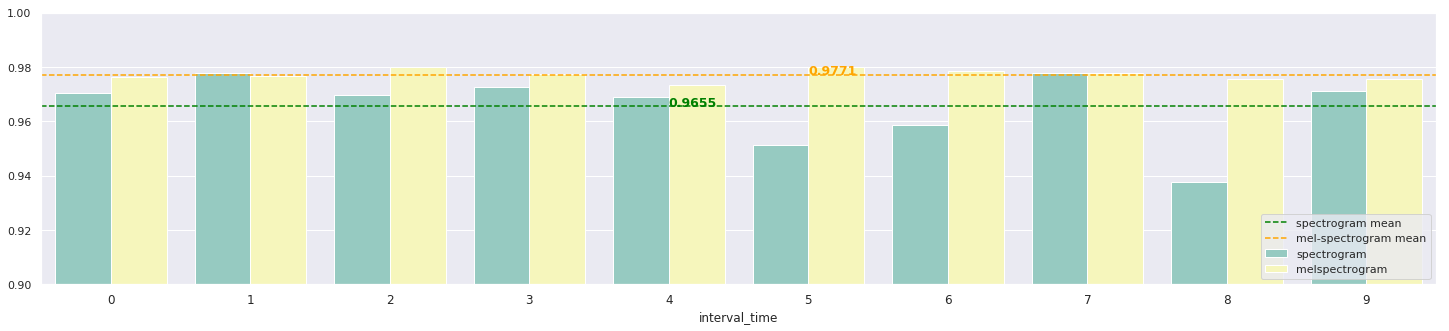

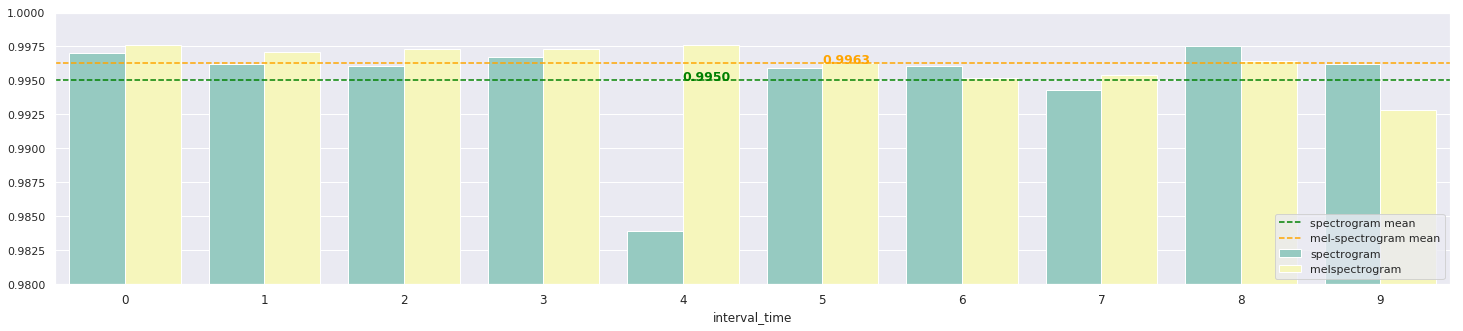

In [56]:
import seaborn as sns

plt.figure(figsize=(20,5))
sns.set(palette='Set3')

fig1, ax1 = plt.subplots(figsize=(25,5))
ax1_sns = sns.barplot(x='interval_time', 
                      y=subdf_cnn3x3input_aucs.subonset_cnn3x3input_auc.values, 
                      hue='input_type', data=subdf_cnn3x3input_aucs)
xticks_loc, _ = plt.xticks(fontsize=12)
subonset_cnn3x3spectrogram_aucs_mean = np.mean(subonset_cnn3x3spectrogram_aucs)
plt.axhline(subonset_cnn3x3spectrogram_aucs_mean, linestyle='--', label='spectrogram mean', color='green')
ax1_sns.text(xticks_loc[4], subonset_cnn3x3spectrogram_aucs_mean, 
             '{:.4f}'.format(subonset_cnn3x3spectrogram_aucs_mean),
             fontsize=12.5, color='green', weight='bold')
subonset_cnn3x3melspectrogram_aucs_mean = np.mean(subonset_cnn3x3melspectrogram_aucs)
plt.axhline(subonset_cnn3x3melspectrogram_aucs_mean, linestyle='--', label='mel-spectrogram mean', color='orange')
ax1_sns.text(xticks_loc[5], subonset_cnn3x3melspectrogram_aucs_mean, 
             '{:.4f}'.format(subonset_cnn3x3melspectrogram_aucs_mean),
             fontsize=12.5, color='orange', weight='bold')
plt.legend(loc='lower right')
plt.ylim([0.9,1])

plt.figure(figsize=(20,5))
fig2, ax2 = plt.subplots(figsize=(25,5))
ax2_sns = sns.barplot(x='interval_time', 
                      y=subdf_cnn3x3input_aucs.subsegment_cnn3x3input_auc.values, 
                      hue='input_type', data=subdf_cnn3x3input_aucs)
xticks_loc, _ = plt.xticks(fontsize=12)
subsegment_cnn3x3spectrogram_aucs_mean = np.mean(subsegment_cnn3x3spectrogram_aucs)
plt.axhline(subsegment_cnn3x3spectrogram_aucs_mean, linestyle='--', label='spectrogram mean', color='green')
ax2_sns.text(xticks_loc[4], subsegment_cnn3x3spectrogram_aucs_mean, 
             '{:.4f}'.format(subsegment_cnn3x3spectrogram_aucs_mean),
             fontsize=12.5, color='green', weight='bold')
subsegment_cnn3x3melspectrogram_aucs_mean = np.mean(subsegment_cnn3x3melspectrogram_aucs)
plt.axhline(subsegment_cnn3x3melspectrogram_aucs_mean, linestyle='--', label='mel-spectrogram mean', color='orange')
ax2_sns.text(xticks_loc[5], subsegment_cnn3x3melspectrogram_aucs_mean, 
             '{:.4f}'.format(subsegment_cnn3x3melspectrogram_aucs_mean),
             fontsize=12.5, color='orange', weight='bold')
plt.legend(loc='lower right')
plt.ylim([0.98,1])

In [55]:
subonset_cnn3x3spectrogram_aucs_var = np.var(subonset_cnn3x3spectrogram_aucs)
subonset_cnn3x3melspectrogram_aucs_var = np.var(subonset_cnn3x3melspectrogram_aucs)
subsegment_cnn3x3spectrogram_aucs_var = np.var(subsegment_cnn3x3spectrogram_aucs)
subsegment_cnn3x3melspectrogram_aucs_var = np.var(subsegment_cnn3x3melspectrogram_aucs)


print('{:^34}'.format('========== cnn3x3 aucs =========='))
print('{:^34}'.format('spectrogram vs mel-spectrogram'))
print('-'*34)
print('{:^16}  {:^16}'.format('onset', 'segment'))
for i,j,k,l in zip(subonset_cnn3x3spectrogram_aucs, 
                   subonset_cnn3x3melspectrogram_aucs,
                   subsegment_cnn3x3spectrogram_aucs, 
                   subsegment_cnn3x3melspectrogram_aucs):
    print("{:.4f} vs {:.4f}  {:.4f} vs {:.4f}".format(i,j,k,l))
print('-'*34)
print('{:^16}  {:^16}'.format('mean', 'mean'))
print("{:.4f} vs {:.4f}  {:.4f} vs {:.4f}".format(subonset_cnn3x3spectrogram_aucs_mean,
                                                  subonset_cnn3x3melspectrogram_aucs_mean,
                                                  subsegment_cnn3x3spectrogram_aucs_mean,
                                                  subsegment_cnn3x3melspectrogram_aucs_mean))
print('-'*34)
print("      onset spec var: {:.9f}".format(subonset_cnn3x3spectrogram_aucs_var))
print("  onset mel-spec var: {:.9f}".format(subonset_cnn3x3melspectrogram_aucs_var))
print("    segment spec var: {:.9f}".format(subsegment_cnn3x3spectrogram_aucs_var))
print("segment mel-spec var: {:.9f}".format(subsegment_cnn3x3melspectrogram_aucs_var))

========== cnn3x3 aucs ========== 
  spectrogram vs mel-spectrogram  
----------------------------------
     onset            segment     
0.9704 vs 0.9764  0.9970 vs 0.9976
0.9777 vs 0.9765  0.9962 vs 0.9971
0.9695 vs 0.9800  0.9961 vs 0.9973
0.9727 vs 0.9773  0.9968 vs 0.9973
0.9687 vs 0.9732  0.9839 vs 0.9976
0.9514 vs 0.9800  0.9959 vs 0.9962
0.9586 vs 0.9784  0.9961 vs 0.9952
0.9776 vs 0.9779  0.9943 vs 0.9954
0.9376 vs 0.9755  0.9976 vs 0.9964
0.9710 vs 0.9757  0.9962 vs 0.9928
----------------------------------
      mean              mean      
0.9655 vs 0.9771  0.9950 vs 0.9963
----------------------------------
      onset spec var: 0.000145149
  onset mel-spec var: 0.000003974
    segment spec var: 0.000014257
segment mel-spec var: 0.000002017


In [62]:
print("Which split index is most closest to the mean value of aucs:")
subonset_cnn3x3spectrogram_splitindx = np.argmin(np.abs(subonset_cnn3x3spectrogram_aucs-subonset_cnn3x3spectrogram_aucs_mean))
subonset_cnn3x3melspectrogram_splitindx = np.argmin(np.abs(subonset_cnn3x3melspectrogram_aucs-subonset_cnn3x3melspectrogram_aucs_mean))
subsegment_cnn3x3spectrogram_splitindx = np.argmin(np.abs(subsegment_cnn3x3spectrogram_aucs-subsegment_cnn3x3spectrogram_aucs_mean))
subsegment_cnn3x3melspectrogram_splitindx = np.argmin(np.abs(subsegment_cnn3x3melspectrogram_aucs-subsegment_cnn3x3melspectrogram_aucs_mean))
print("      onset spec: {}".format(subonset_cnn3x3spectrogram_splitindx))
print("  onset mel-spec: {}".format(subonset_cnn3x3melspectrogram_splitindx))
print("    segment spec: {}".format(subsegment_cnn3x3spectrogram_splitindx))
print("segment mel-spec: {}".format(subsegment_cnn3x3melspectrogram_splitindx))

Which split index is most closest to the mean value of aucs:
      onset spec: 4
  onset mel-spec: 3
    segment spec: 7
segment mel-spec: 5


Then we run 10 times for each selected split:
```
python subdf_cnn3x3input.py onset spectrogram 4
python subdf_cnn3x3input.py onset melspectrogram 3
python subdf_cnn3x3input.py segment spectrogram 7
python subdf_cnn3x3input.py segment melspectrogram 5
```

This returns performance scores in order to get confidence interval, which indicates how significant an effect is when a parameter is changed in the further experiemnts.

In [7]:
split_kv = {'onset-spectrogram':4, 'onset-melspectrogram':3, 
            'segment-spectrogram':7, 'segment-melspectrogram':5}

subdf_cnn3x3input_tracks = pd.DataFrame()
for dataset_type,input_type in zip(['onset','onset','segment','segment'],
                                   ['spectrogram','melspectrogram','spectrogram','melspectrogram']):
    split_indx = split_kv['{}-{}'.format(dataset_type,input_type)]
    csv_name = 'sub{}_cnn3x3{}_split{}.csv'.format(dataset_type, input_type, split_indx)
    csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
    subdf_cnn3x3input_track = pd.read_csv(csv_path)

    subdf_cnn3x3input_tracks = pd.concat([subdf_cnn3x3input_tracks, subdf_cnn3x3input_track])

onset_input = subdf_cnn3x3input_tracks.loc[subdf_cnn3x3input_tracks['dataset_type']=='onset']
onset_spectrogram = onset_input.loc[onset_input['input_type']=='spectrogram']
onset_melspectrogram = onset_input.loc[onset_input['input_type']=='melspectrogram']

segment_input = subdf_cnn3x3input_tracks.loc[subdf_cnn3x3input_tracks['dataset_type']=='segment']
segment_spectrogram = segment_input.loc[onset_input['input_type']=='spectrogram']
segment_melspectrogram = segment_input.loc[onset_input['input_type']=='melspectrogram']

onsetspec_acc_mean, onsetspec_acc_std = np.mean(onset_spectrogram.subdf_cnn3x3input_acc.values),np.std(onset_spectrogram.subdf_cnn3x3input_acc.values)
onsetspec_auc_mean, onsetspec_auc_std = np.mean(onset_spectrogram.subdf_cnn3x3input_auc.values),np.std(onset_spectrogram.subdf_cnn3x3input_auc.values)
onsetmel_acc_mean, onsetmel_acc_std = np.mean(onset_melspectrogram.subdf_cnn3x3input_acc.values),np.std(onset_melspectrogram.subdf_cnn3x3input_acc.values)
onsetmel_auc_mean, onsetmel_auc_std = np.mean(onset_melspectrogram.subdf_cnn3x3input_auc.values),np.std(onset_melspectrogram.subdf_cnn3x3input_auc.values)

segspec_acc_mean, segspec_acc_std = np.mean(segment_spectrogram.subdf_cnn3x3input_acc.values),np.std(segment_spectrogram.subdf_cnn3x3input_acc.values)
segspec_auc_mean, segspec_auc_std = np.mean(segment_spectrogram.subdf_cnn3x3input_auc.values),np.std(segment_spectrogram.subdf_cnn3x3input_auc.values)
segmel_acc_mean, segmel_acc_std = np.mean(segment_melspectrogram.subdf_cnn3x3input_acc.values),np.std(segment_melspectrogram.subdf_cnn3x3input_acc.values)
segmel_auc_mean, segmel_auc_std = np.mean(segment_melspectrogram.subdf_cnn3x3input_auc.values),np.std(segment_melspectrogram.subdf_cnn3x3input_auc.values)

onsetspec_acc_max = onsetspec_acc_mean+onsetspec_acc_std
onsetspec_auc_max = onsetspec_auc_mean+onsetspec_auc_std
onsetmel_acc_max = onsetmel_acc_mean+onsetmel_acc_std
onsetmel_auc_max = onsetmel_auc_mean+onsetmel_auc_std

segspec_acc_max = segspec_acc_mean+segspec_acc_std
segspec_auc_max = segspec_auc_mean+segspec_auc_std
segmel_acc_max = segmel_acc_mean+segmel_acc_std
segmel_auc_max = segmel_auc_mean+segmel_auc_std

In [8]:
print("input effect on cnn3x3: {:^8}, {:^8}, {:^8}".format('mean', 'std', 'max'))
print("-"*53)
print(" onset spectrogram acc: {:6f}, {:6f}, {:6f}".format(onsetspec_acc_mean,onsetspec_acc_std, onsetspec_acc_max))
print(" onset spectrogram auc: {:6f}, {:6f}, {:6f}".format(onsetspec_auc_mean,onsetspec_auc_std, onsetspec_auc_max))
print(" onset melspecgram acc: {:6f}, {:6f}, {:6f}".format(onsetmel_acc_mean,onsetmel_acc_std, onsetmel_acc_max))
print(" onset melspecgram auc: {:6f}, {:6f}, {:6f}".format(onsetmel_auc_mean,onsetmel_auc_std, onsetmel_auc_max))
print("-"*53)
print("   seg spectrogram acc: {:6f}, {:6f}, {:6f}".format(segspec_acc_mean,segspec_acc_std, segspec_acc_max))
print("   seg spectrogram auc: {:6f}, {:6f}, {:6f}".format(segspec_auc_mean,segspec_auc_std, segspec_auc_max))
print("   seg melspecgram acc: {:6f}, {:6f}, {:6f}".format(segmel_acc_mean,segmel_acc_std, segmel_acc_max))
print("   seg melspecgram auc: {:6f}, {:6f}, {:6f}".format(segmel_auc_mean,segmel_auc_std, segmel_auc_max))

input effect on cnn3x3:   mean  ,   std   ,   max   
-----------------------------------------------------
 onset spectrogram acc: 0.897611, 0.019068, 0.916680
 onset spectrogram auc: 0.967773, 0.007441, 0.975214
 onset melspecgram acc: 0.919794, 0.010232, 0.930027
 onset melspecgram auc: 0.976562, 0.003250, 0.979812
-----------------------------------------------------
   seg spectrogram acc: 0.954462, 0.020886, 0.975348
   seg spectrogram auc: 0.992508, 0.005118, 0.997626
   seg melspecgram acc: 0.975540, 0.006145, 0.981685
   seg melspecgram auc: 0.996258, 0.001816, 0.998074


Use the same split, we test on the effects of different kernel shape:
```
python subdf_cnnkernel.py onset spectrogram
python subdf_cnnkernel.py onset melspectrogram
python subdf_cnnkernel.py segment spectrogram
python subdf_cnnkernel.py segment melspectrogram
```
Best results along the frequency or time axis are:

In [9]:
subdf_cnnkernel_tracks = pd.DataFrame()
for dataset_type,input_type in zip(['onset','onset','segment','segment'],
                                   ['spectrogram','melspectrogram','spectrogram','melspectrogram']):
    csv_name = 'sub{}_cnnkernel_{}.csv'.format(dataset_type, input_type)
    csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
    subdf_cnnkernel_track = pd.read_csv(csv_path)

    subdf_cnnkernel_tracks = pd.concat([subdf_cnnkernel_tracks, subdf_cnnkernel_track])

onset_input = subdf_cnnkernel_tracks.loc[subdf_cnnkernel_tracks['dataset_type']=='onset']
onset_spectrogram = onset_input.loc[onset_input['input_type']=='spectrogram']
onset_melspectrogram = onset_input.loc[onset_input['input_type']=='melspectrogram']

segment_input = subdf_cnnkernel_tracks.loc[subdf_cnnkernel_tracks['dataset_type']=='segment']
segment_spectrogram = segment_input.loc[onset_input['input_type']=='spectrogram']
segment_melspectrogram = segment_input.loc[onset_input['input_type']=='melspectrogram']

In [10]:
onset_input

,Unnamed: 0,subdf_cnnkernel_acc,subdf_cnnkernel_auc,dataset_type,input_type,n_freq,n_time
0,0,0.886268,0.967040,onset,spectrogram,6,3
1,1,0.914138,0.973482,onset,spectrogram,15,3
2,2,0.920898,0.977411,onset,spectrogram,36,3
3,3,0.924805,0.979014,onset,spectrogram,3,10
4,4,0.930739,0.981743,onset,spectrogram,3,20
5,5,0.916692,0.974949,onset,spectrogram,3,30
0,0,0.909255,0.970165,onset,melspectrogram,9,3
1,1,0.923603,0.975790,onset,melspectrogram,20,3
2,2,0.916917,0.974043,onset,melspectrogram,45,3
3,3,0.934570,0.982690,onset,melspectrogram,3,10


In [11]:
onsetspec_nfreq = onset_spectrogram.iloc[2].n_freq
onsetspec_auc_freqmax = onset_spectrogram.iloc[2].subdf_cnnkernel_auc
onsetspec_auc_freqsig = 0
if onsetspec_auc_freqmax>onsetspec_auc_max: onsetspec_auc_freqsig = 1

onsetspec_ntime = onset_spectrogram.iloc[4].n_time
onsetspec_auc_timemax = onset_spectrogram.iloc[4].subdf_cnnkernel_auc
onsetspec_auc_timesig = 0
if onsetspec_auc_timemax>onsetspec_auc_max: onsetspec_auc_timesig = 1
    
onsetmel_nfreq = onset_melspectrogram.iloc[1].n_freq
onsetmel_auc_freqmax = onset_melspectrogram.iloc[1].subdf_cnnkernel_auc
onsetmel_auc_freqsig = 0
if onsetmel_auc_freqmax>onsetmel_auc_max: onsetmel_auc_freqsig = 1
    
onsetmel_ntime = onset_melspectrogram.iloc[3].n_time
onsetmel_auc_timemax = onset_melspectrogram.iloc[3].subdf_cnnkernel_auc
onsetmel_auc_timesig = 0
if onsetmel_auc_timemax>onsetmel_auc_max: onsetmel_auc_timesig = 1

In [12]:
print("   kernel effect on onset: {:^6}, {:^6}, {:^8}, {:^3}, {:^8}".format('n_freq', 'n_time', 'auc', 'sig', '3x3mean'))
print("-"*66)
print("    spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(onsetspec_nfreq, '3', onsetspec_auc_freqmax, onsetspec_auc_freqsig, onsetspec_auc_mean))
print("    spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', onsetspec_ntime, onsetspec_auc_timemax, onsetspec_auc_timesig, onsetspec_auc_mean))
print("mel spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(onsetmel_nfreq, '3', onsetmel_auc_freqmax, onsetmel_auc_freqsig, onsetmel_auc_mean))
print("mel spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', onsetmel_ntime, onsetmel_auc_timemax, onsetmel_auc_timesig, onsetmel_auc_mean))

   kernel effect on onset: n_freq, n_time,   auc   , sig, 3x3mean 
------------------------------------------------------------------
    spectrogram freq axis:   36  ,   3   , 0.977411,  1 , 0.967773
    spectrogram time axis:   3   ,   20  , 0.981743,  1 , 0.967773
mel spectrogram freq axis:   20  ,   3   , 0.975790,  0 , 0.976562
mel spectrogram time axis:   3   ,   10  , 0.982690,  1 , 0.976562


In [13]:
segment_input

,Unnamed: 0,subdf_cnnkernel_acc,subdf_cnnkernel_auc,dataset_type,input_type,n_freq,n_time
0,0,0.958924,0.996912,segment,spectrogram,6,3
1,1,0.971408,0.995389,segment,spectrogram,15,3
2,2,0.969716,0.994546,segment,spectrogram,36,3
3,3,0.980670,0.997830,segment,spectrogram,3,10
4,4,0.984536,0.998020,segment,spectrogram,3,20
5,5,0.975274,0.996416,segment,spectrogram,3,30
0,0,0.963032,0.990533,segment,melspectrogram,9,3
1,1,0.975113,0.995612,segment,melspectrogram,20,3
2,2,0.974710,0.996849,segment,melspectrogram,45,3
3,3,0.981476,0.997321,segment,melspectrogram,3,10


In [14]:
segspec_nfreq = segment_spectrogram.iloc[1].n_freq
segspec_auc_freqmax = segment_spectrogram.iloc[1].subdf_cnnkernel_auc
segspec_auc_freqsig = 0
if segspec_auc_freqmax>segspec_auc_max: segspec_auc_freqsig = 1

segspec_ntime = segment_spectrogram.iloc[4].n_time
segspec_auc_timemax = segment_spectrogram.iloc[4].subdf_cnnkernel_auc
segspec_auc_timesig = 0
if segspec_auc_timemax>segspec_auc_max: segspec_auc_timesig = 1
    
segmel_nfreq = segment_melspectrogram.iloc[2].n_freq
segmel_auc_freqmax = segment_melspectrogram.iloc[2].subdf_cnnkernel_auc
segmel_auc_freqsig = 0
if segmel_auc_freqmax>segmel_auc_max: segmel_auc_freqsig = 1
    
segmel_ntime = segment_melspectrogram.iloc[3].n_time
segmel_auc_timemax = segment_melspectrogram.iloc[3].subdf_cnnkernel_auc
segmel_auc_timesig = 0
if segmel_auc_timemax>segmel_auc_max: segmel_auc_timesig = 1

In [15]:
print(" kernel effect on segment: {:^6}, {:^6}, {:^8}, {:^3}, {:^8}".format('n_freq', 'n_time', 'auc', 'sig', '3x3mean'))
print("-"*66)
print("    spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(segspec_nfreq, '3', segspec_auc_freqmax, segspec_auc_freqsig, segspec_auc_mean))
print("    spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', segspec_ntime, segspec_auc_timemax, segspec_auc_timesig, segspec_auc_mean))
print("mel spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(segmel_nfreq, '3', segmel_auc_freqmax, segmel_auc_freqsig, segmel_auc_mean))
print("mel spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', segmel_ntime, segmel_auc_timemax, segmel_auc_timesig, segmel_auc_mean))

 kernel effect on segment: n_freq, n_time,   auc   , sig, 3x3mean 
------------------------------------------------------------------
    spectrogram freq axis:   15  ,   3   , 0.995389,  0 , 0.992508
    spectrogram time axis:   3   ,   20  , 0.998020,  1 , 0.992508
mel spectrogram freq axis:   45  ,   3   , 0.996849,  0 , 0.996258
mel spectrogram time axis:   3   ,   10  , 0.997321,  0 , 0.996258


Use the value of `n_freq` and `n_time` which returns the highest auc to run:
```
python subdf_cnnkernel_multi.py onset spectrogram
python subdf_cnnkernel_multi.py onset melspectrogram
python subdf_cnnkernel_multi.py segment spectrogram
python subdf_cnnkernel_multi.py segment melspectrogram
```

Within the code:
```
    if dataset_type == 'onset':
        typeshape = ONSET_INPUT_SHAPE
        batch_size = 256
        
        if input_type == 'spectrogram':
            n_freqs = [36,3,3]
            n_times = [3,3,20]
        elif input_type == 'melspectrogram':
            n_freqs = [20,3,3]
            n_times = [3,3,10]
        else:
            print("ERROR: Input type must be either spectrogram or melspectrogram!")
    elif dataset_type == 'segment':
        typeshape = SEGMENT_INPUT_SHAPE
        batch_size = 128
        
        if input_type == 'spectrogram':
            n_freqs = [15,3,3]
            n_times = [3,3,20]
        elif input_type == 'melspectrogram':
            n_freqs = [45,3,3]
            n_times = [3,3,10]
        else:
            print("ERROR: Input type must be either spectrogram or melspectrogram!")        
    else:
        print("ERROR: Dataset type must be either onset or segment!")
```

In [16]:
subdf_cnnkernelmulti_tracks = pd.DataFrame()
for dataset_type,input_type in zip(['onset','onset','segment','segment'],
                                   ['spectrogram','melspectrogram','spectrogram','melspectrogram']):
    csv_name = 'sub{}_cnnkernelmulti_{}.csv'.format(dataset_type, input_type)
    csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
    subdf_cnnkernelmulti_track = pd.read_csv(csv_path)

    subdf_cnnkernelmulti_tracks = pd.concat([subdf_cnnkernelmulti_tracks, subdf_cnnkernelmulti_track])

onset_input = subdf_cnnkernelmulti_tracks.loc[subdf_cnnkernelmulti_tracks['dataset_type']=='onset']
onset_spectrogram = onset_input.loc[onset_input['input_type']=='spectrogram']
onset_melspectrogram = onset_input.loc[onset_input['input_type']=='melspectrogram']

segment_input = subdf_cnnkernelmulti_tracks.loc[subdf_cnnkernelmulti_tracks['dataset_type']=='segment']
segment_spectrogram = segment_input.loc[onset_input['input_type']=='spectrogram']
segment_melspectrogram = segment_input.loc[onset_input['input_type']=='melspectrogram']

onsetspec_auc_multi = onset_spectrogram.subdf_cnnkernel_auc[0]
onsetspec_auc_multisig = 0
if onsetspec_auc_multi>onsetspec_auc_max: onsetspec_auc_multisig = 1
    
onsetmel_auc_multi = onset_melspectrogram.subdf_cnnkernel_auc[0]
onsetmel_auc_multisig = 0
if onsetmel_auc_multi>onsetmel_auc_max: onsetmel_auc_multisig = 1

segspec_auc_multi = segment_spectrogram.subdf_cnnkernel_auc[0]
segspec_auc_multisig = 0
if segspec_auc_multi>segspec_auc_max: segspec_auc_multisig = 1
    
segmel_auc_multi = segment_melspectrogram.subdf_cnnkernel_auc[0]
segmel_auc_multisig = 0
if segmel_auc_multi>segmel_auc_max: segmel_auc_multisig = 1

In [17]:
segment_melspectrogram

,Unnamed: 0,subdf_cnnkernel_acc,subdf_cnnkernel_auc,dataset_type,input_type,n_freq,n_time
0,0,0.983731,0.998281,segment,melspectrogram,45,10


In [18]:
csv_name = 'subdf_cnn_segmel_lc.csv'
csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
subdf_cnnsegmel_lc = pd.read_csv(csv_path)
subdf_cnnsegmel_lc

,Unnamed: 0,subdf_cnnkernel_acc,subdf_cnnkernel_auc,dataset_type,input_type,n_layer,n_channel
0,0,0.976240,0.996352,segment,melspectrogram,4,4
1,1,0.951273,0.986978,segment,melspectrogram,4,1
2,2,0.974146,0.995974,segment,melspectrogram,3,7
3,3,0.970844,0.994754,segment,melspectrogram,3,4
4,4,0.943621,0.984885,segment,melspectrogram,3,1
5,5,0.955219,0.989027,segment,melspectrogram,2,7
6,6,0.938869,0.980417,segment,melspectrogram,2,4
7,7,0.878141,0.948604,segment,melspectrogram,2,1


The best auc of onset excerpts uses mel spectrogram as input, kernel is 3x10.

The best auc of segment excerpts uses mel spectrogram as input, kernel is multiple, 45x3+3x3+3x10.

---

We try the onset-mel cnn-3x10 with two more convolutional layers: 
```
python subdf_cnn3x10_onsetmel_l.py
```

We try the seg-mel cnn-multi with less layers and less channels:
```
python subdf_cnn_segmel_lc.py
```

BUT none of them performs better!

---

Test with LeakyRelu activations:

```
python subdf_cnn_act.py
```

In [28]:
csv_name = 'subdf_cnn_act.csv'
csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
subdf_cnnact_track = pd.read_csv(csv_path)

onset_input = subdf_cnnact_track.loc[subdf_cnnact_track['dataset_type']=='onset']
onset_melspectrogram = onset_input.loc[onset_input['input_type']=='melspectrogram']
onsetmel_auc_LeakyReLU = onset_melspectrogram.subdf_cnnkernel_auc.values[0]
onsetmel_auc_LeakyReLUsig = 0
if onsetmel_auc_LeakyReLU>onsetmel_auc_max: onsetmel_auc_LeakyReLUsig = 1
    
segment_input = subdf_cnnact_track.loc[subdf_cnnact_track['dataset_type']=='segment']
segment_melspectrogram = segment_input.loc[segment_input['input_type']=='melspectrogram']
segmel_auc_LeakyReLU = segment_melspectrogram.subdf_cnnkernel_auc.values[0]
segmel_auc_LeakyReLUsig = 0
if segmel_auc_LeakyReLU>segmel_auc_max: segmel_auc_LeakyReLUsig = 1

In [36]:
print("   kernel effect on onset: {:^6}, {:^6}, {:^8}, {:^3}, {:^8}".format('n_freq', 'n_time', 'auc', 'sig', '3x3mean'))
print("-"*66)
print("    spectrogram 3x3kernel: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', '3', onsetspec_auc_max, 'n/a', onsetspec_auc_mean))
print("    spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(onsetspec_nfreq, '3', onsetspec_auc_freqmax, onsetspec_auc_freqsig, onsetspec_auc_mean))
print("    spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', onsetspec_ntime, onsetspec_auc_timemax, onsetspec_auc_timesig, onsetspec_auc_mean))
print("    spectrogram BOTH axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('multi', 'multi', onsetspec_auc_multi, onsetspec_auc_multisig, onsetspec_auc_mean))
print("mel spectrogram 3x3kernel: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', '3', onsetmel_auc_max, 'n/a', onsetmel_auc_mean))
print("mel spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(onsetmel_nfreq, '3', onsetmel_auc_freqmax, onsetmel_auc_freqsig, onsetmel_auc_mean))
print("mel spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f} *".format('3', onsetmel_ntime, onsetmel_auc_timemax, onsetmel_auc_timesig, onsetmel_auc_mean))
print("mel spectrogram BOTH axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('multi', 'multi', onsetmel_auc_multi, onsetmel_auc_multisig, onsetmel_auc_mean))
print("mel spectrogram LeakyReLU: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', '10', onsetmel_auc_LeakyReLU, onsetmel_auc_LeakyReLUsig, onsetmel_auc_mean))

print("-"*66)
print(" kernel effect on segment: {:^6}, {:^6}, {:^8}, {:^3}, {:^8}".format('n_freq', 'n_time', 'auc', 'sig', '3x3mean'))
print("-"*66)
print("    spectrogram 3x3kernel: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', '3', segspec_auc_max, 'n/a', segspec_auc_mean))
print("    spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(segspec_nfreq, '3', segspec_auc_freqmax, segspec_auc_freqsig, segspec_auc_mean))
print("    spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', segspec_ntime, segspec_auc_timemax, segspec_auc_timesig, segspec_auc_mean))
print("    spectrogram BOTH axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('multi', 'multi', segspec_auc_multi, segspec_auc_multisig, segspec_auc_mean))
print("mel spectrogram 3x3kernel: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', '3', segmel_auc_max, 'n/a', segmel_auc_mean))
print("mel spectrogram freq axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format(segmel_nfreq, '3', segmel_auc_freqmax, segmel_auc_freqsig, segmel_auc_mean))
print("mel spectrogram time axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('3', segmel_ntime, segmel_auc_timemax, segmel_auc_timesig, segmel_auc_mean))
print("mel spectrogram BOTH axis: {:^6}, {:^6}, {:6f}, {:^3}, {:6f} *".format('multi', 'multi', segmel_auc_multi, segmel_auc_multisig, segmel_auc_mean))
print("mel spectrogram LeakyReLU: {:^6}, {:^6}, {:6f}, {:^3}, {:6f}".format('multi', 'multi', segmel_auc_LeakyReLU, segmel_auc_LeakyReLUsig, segmel_auc_mean))


   kernel effect on onset: n_freq, n_time,   auc   , sig, 3x3mean 
------------------------------------------------------------------
    spectrogram 3x3kernel:   3   ,   3   , 0.975214, n/a, 0.967773
    spectrogram freq axis:   36  ,   3   , 0.977411,  1 , 0.967773
    spectrogram time axis:   3   ,   20  , 0.981743,  1 , 0.967773
    spectrogram BOTH axis: multi , multi , 0.980067,  1 , 0.967773
mel spectrogram 3x3kernel:   3   ,   3   , 0.979812, n/a, 0.976562
mel spectrogram freq axis:   20  ,   3   , 0.975790,  0 , 0.976562
mel spectrogram time axis:   3   ,   10  , 0.982690,  1 , 0.976562 *
mel spectrogram BOTH axis: multi , multi , 0.975477,  0 , 0.976562
mel spectrogram LeakyReLU:   3   ,   10  , 0.979376,  0 , 0.976562
------------------------------------------------------------------
 kernel effect on segment: n_freq, n_time,   auc   , sig, 3x3mean 
------------------------------------------------------------------
    spectrogram 3x3kernel:   3   ,   3   , 0.997626, n/a, 0.

Test seg-mel cnn-multi with L2 and dropout:
```
python subdf_cnn_segmel_opt.py
```

In [39]:
csv_name = 'subsegment_cnn_melspectrogram_opt.csv'.format(dataset_type, input_type)
csv_path = os.path.join(DIR_SAVE_MODEL, csv_name)
subdf_segmel_track = pd.read_csv(csv_path)
    
segmel_input = subdf_segmel_track.loc[subdf_segmel_track['opt_type']=='l2']
segmel_auc_l2 = segmel_input.subdf_cnnkernel_auc.values[0]

segmel_input = subdf_segmel_track.loc[subdf_segmel_track['opt_type']=='l2dropout']
segmel_auc_l2dropout = segmel_input.subdf_cnnkernel_auc.values[0]

print("opt effect on segment melspectrogram")
print("multi kernel: {:^8}, {:<9}".format('auc', 'opt'))
print("-"*66)
print("              {:6f}, {:<9}".format(segmel_auc_multi,     'n/a'))
print("              {:6f}, {:<9}".format(segmel_auc_l2,        'l2'))
print("              {:6f}, {:<9}".format(segmel_auc_l2dropout, 'l2dropout'))

opt effect on segment melspectrogram
multi kernel:   auc   , opt      
------------------------------------------------------------------
              0.998281, n/a      
              0.996856, l2       
              0.996708, l2dropout
